# Symbolic Methods - Lab 1

In [1]:
from IPython.core.display import HTML
css_file = './ngcmstyle.css'
HTML(open(css_file, "r").read())

import numpy
import sympy
sympy.init_printing()

Aim: write a generator function to do central finite differencing at arbitrary order, using sympy. Test it on both scripted python and compiled C code.

## Mathematics

The central difference approximation to the first derivative uses Taylor series expansion to match to the first derivative term. That is, we approximate

$$
\begin{equation}
  \left. \frac{d \, f}{d \, x} \right|_{x = X} = c_0 f(X) + \sum_{i = 1}^{n} c_n \left( f(X + n h) - f(X - n h) \right) + {\cal O}(h^{2 n +1}).
\end{equation}
$$

The order of accuracy is $2 n$, which must be even.

This must be true for any function. For simplicity we can do the Taylor expansion to calculate the unknown coefficients $c_n$ by only considering $f(x) = \exp(x)$: as the coefficients are independent of the function, the resulting approximation holds for all (suitably differentiable) functions.

By subsituting in $f(x) = \exp(x)$ and performing the series expansion about $x = X$ with small parameter $h$, we can match the terms on both sides of the expression in orders of $h$. That is, terms with common factor $h^0$ must vanish, terms with common factor $h^1$ must give the derivative (which, when removing the common $\exp(x)$ term, means they must give $1$), and terms with common factor $h^j$ for $j > 1$ must vanish. This gives a system of $n$ linear equations that can be solved for the $c_n$.

Note that, by construction, all terms with even powers in $h$ (except $h^0$) vanish identically. So whilst the series is expanded to order $2n+1$, only the $n$ terms corresponding to the odd powers of $h$ are interesting.

## Useful functions

This list of functions, all from `sympy`, will be useful in forming your solution.

* `symbols`: create a symbol. Note that `c=symbols(c:3)` creates e.g. `c[0]=c0`, `c[1]=c1` and `c[2]=c2`.
* `exp`: the exponential in `sympy`
* `series`: Taylor series expansion about a point
* `removeO`: method that removes the ${\cal O}$ term from a series
* `expand`: expands out all terms - might be needed before some simplifications
* `collect`: collects terms with like powers of a given variable: returns a dictionary
* `coeff`: returns the coefficient corresponding to a given variable
* `zeros`: creates the zero matrix (or vector) of given size
* `solve`: method applied to a matrix to solve the linear problem $A {\bf x} = {\bf b}$ via `x=A.solve(b)`
* `sympy.utilities.lambdify`: as in lectures, constructs a python function that can be numerically evaluated.

## Task - python

Objective: write a function `central_differencing` that takes as input a positive, even integer `order`. The function should *derive*, from the Taylor series expansion, the coefficients $c_n$, and from those coefficients generate a function `df`. Only the function `df` should be returned. `df` should take as input an arbitrary function of one variable `f`, the point `X` at which the derivative is to be evaluated, and the step length `h`.

### Taylor expansion

Write a function `taylor_exp` that returns the Taylor series 
\begin{equation}
\exp(x_i(h)) = \exp(x_0) + h \exp(x_0) + \frac{h^2}{2} \exp(x_0) + ... + \frac{h^n}{n!} \exp ( x_0)
\end{equation}

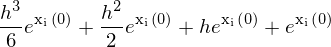

In [22]:
def taylor_exp(x_i, h, n):
    """Return Taylor series of exp(xi(h)) about h=0 to order n,
    where xi(h) is an arbitrary Sympy expression that depends on h,
    such as xi(h) = x + i * h.

    The Taylor series should be of the form
         exp(xi(h)) = exp(x0) + h * exp(x0) + h^2/2 * exp(x0) + ... + h^{2n + 1}/(2n + 1)! * exp(x0) + O(h^{2n+2},
    where x0 = xi(0).

    Parameters
    ----------
    x : sympy symbol
    h : sympy symbol
    n : integer
    """
    
    x_0 = x_i.subs(h, 0)
    exp = sympy.exp(h)
    return sympy.expand(exp.series(n=n)*sympy.exp(x_0)).removeO()



def test_taylor_exp():
    """Test the function 'taylor_exp'
    """
    n=4
    x, h = sympy.symbols('x, h')
    x_i = sympy.Function('x_i')(h)
    return taylor_exp(x_i, h, n)



test_taylor_exp()

### Difference equation

Define a function that returns the finite difference expression on the right hand side of the equation 

\begin{equation}
  f'(X) = c_0 f(X) + \sum_{i = 1}^{n} c_n \left( f(X + n h) - f(X - n h) \right)
\end{equation}

In [33]:
def diff(f, x, h, c, n):
    """Given a function f(x) , and a list of n
    coefficients c, return
         c0 f(x) + sum_i=1^n { ci (f(x + i*h) - f(x - i*h)) },
    where x and h are symbolic constants.
    """
    return c[0]*f(x) + sum([c[n]*(f(x+n*h) - f(x-n*h)) for n in range(1, order+1) ])
    
    
    
def test_diff():
    order = 4
    c = sympy.symbols('c:{}'.format(order+1))
    x, n, h = sympy.symbols('x, n, h')
    f = sympy.Function('f')
    return diff(f, x, h, c, n)



test_diff()

### System of equations for the coefficients $(c_i)$
Evaluating the difference equation for $f = \exp$, and expanding $f$ about $X$ using a Taylor series leads to a polynomial of $h$ which must be 0 everywhere. This is only possible if all the coefficients of the polynomial are 0. This can be used to define the system of equations that the coefficients $c_i$ should satisfy.

In [ ]:
def polynomial_coefs(poly, h):
    """Return the coefficients of the input polynomical
        P(h) = a0 + a1 h + a2 h^2 + ....
    as a dictionary 'coefs' with keys [1, h, h^2, ...,] and values [a0, a1, ....],
    so that
    coefs[h^i] = ai
    """
    return poly.collect(h, evaluate=False)


def equations(dexp_expansion, h):
    """Given a Taylor expansion of the difference equation
         df(x) = c0 f(x) + sum_i=1^n { ci (f(x + i*h) - f(x - i*h)) },
    return the list of equations [eq1, eq2, ....], defined in terms of
    SymPy expressions such that each equation is given by
         eqi = 0.
    """
    hcoefs = polynomial_coefs(dexp_expansion, h)
    # TODO: modify the values of the coefficients appropriately
    # Note that hcoefs is a dictionary
    return hcoefs.values()


### Central differencing function

In [ ]:
def central_differencing(order, c_code=False, debug=DEBUG):
    """Return a function diff(f, x, h) that computes the first
    derivative of a function of one variable 'f' at point 'x', using a
    central difference scheme of order 'order' with step 'h'.

    {df/dx}(x) = c0 f(x) + sum_i=1^n { ci (f(x + i*h) - f(x - i*h)) }

    Arguments
    ---------
    order : integer
         Even integer giving the order of the scheme.

    """
    assert order % 2 == 0
    n = order / 2
    c = sympy.symbols('c:%d' % (n + 1))

    x, h = sympy.symbols('x, h')

    # Use Taylor series of exp(x + i*h) about h=0 to order 2n+1 to
    # expand the terms of the form f(x + i*h) in our difference
    # equation.
    texp = lambda xi: taylor_exp(xi, h, 2 * n + 1)
    df = diff(texp, x, h, c, n)
    df = df.expand().removeO()
    # The exp(x0) cancels with the left hand side whatever the order
    df = (df / sympy.exp(x)).expand()
    if debug:
        print 'df = ', df

    # Collect the coefficients of the polynomial in h in dict hcoefs
    # and setup the list of equations
    eqs = equations(df, h)

    # Solve the equation and transform the dict of results into a list
    #cdict = sympy.solve(hcoefs.values(), *c)
    cdict = sympy.solve(eqs, *c)
    if debug:
        print 'Solve for c coefficients:'
    coefs = []
    for ci in c:
        coefs.append(cdict[ci])
        if debug:
            print '  ', str(ci) + ' = ' + str(cdict[ci])

    # Construct function of f, x and h that returns derivative using lambdify
    f = sympy.Function('f')
    expr = diff(f, x, h, coefs, n)
    if debug:
        print 'Scheme: ', expr
    if c_code:
        from sympy.utilities.codegen import codegen
        # Use the codegen sympy function to generate the c-code
        # TODO: fill the dots
        # files = codegen(.....)
        for filename, contents in files:
            print '* ', filename, ' *'
            print contents
    return sympy.lambdify((f, x, h), expr)


Test your function for orders $2, 4, 6, 8$. When applied to the exponential function (`numpy.exp`) at the origin you can compute the error as

$$
  \text{Error}_{h, \text{order}} = \big| {\tt df}({\tt numpy.exp}, 0.0, h) - 1 \big|.
$$

You should find your error scales as $h^{\text{order}}$. Test this by computing the error when $h = 2^{-i}$ for $i = 0, \dots, 5$ and fitting a straight line through the computed errors, using something like

`p = numpy.polyfit(log(H), log(Error), 1)`

where `p[0]` gives the convergence rate.

## Task - C

Modify your function to generate C code. Test it on a more complex function of your choice, evaluated at a specific point. You may wish to use `sympy` to evaluate the derivative in order to test your result.